# Parameter identification example

Here is a simple toy model that we use to demonstrate the working of the inference package

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *
import numpy as np
import pylab as plt
import pandas as pd
M = Model('toy_model.xml')

# Generate experimental data
1. Simulate bioscrape model
2. Add Gaussian noise of non-zero mean and non-zero variance to the simulation
3. Create appropriate Pandas dataframes 
4. Write the data to a CSV file

In [3]:
timepoints = np.linspace(0,20,100)
result = py_simulate_model(timepoints, Model = M)['X']

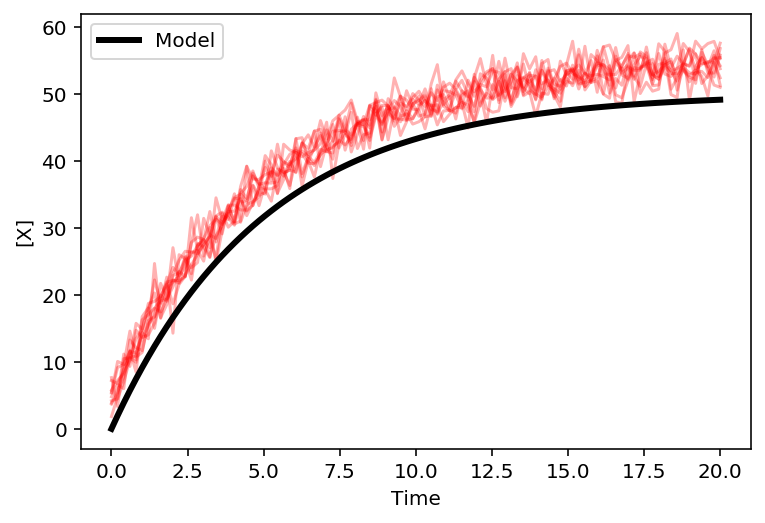

In [4]:
num_trajectories = 10
exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result + np.random.normal(5, 2, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
plt.plot(timepoints, result, 'k', linewidth = 3, label = 'Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()


## CSV looks like:


In [5]:
exp_data.to_csv('birth_death_data.csv')
exp_data

,timepoints,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,0.000000,4.788361,1.830763,7.197785,5.447643,3.849972,5.339047,3.680521,7.639550,4.178843,5.734387
1,0.202020,6.560437,4.803369,6.773111,9.141774,5.635558,10.051054,5.347702,3.313567,4.479466,7.226357
2,0.404040,5.996415,11.146793,8.629225,9.604417,7.736040,9.607936,8.989750,10.471325,6.985028,8.228127
3,0.606061,13.250566,9.315927,11.566614,14.577872,11.725345,11.559505,10.572064,10.590193,10.358282,10.223403
4,0.808081,12.109044,14.701559,11.308852,10.688798,8.459170,10.282540,9.920012,10.908147,13.460230,15.736940
...,...,...,...,...,...,...,...,...,...,...,...
95,19.191919,51.518076,52.045620,53.522956,54.092264,55.946440,52.934473,55.876271,53.131071,57.822280,53.679724
96,19.393939,56.200608,56.555750,52.550034,55.387062,51.490294,55.319776,54.478744,53.312743,56.667780,54.335759
97,19.595960,54.252159,53.080647,49.622131,53.700718,52.665863,53.978711,54.579733,52.385022,57.460941,54.779940
98,19.797980,52.466742,53.063432,55.404852,51.272967,54.632878,56.381262,55.266595,55.687269,57.792009,54.620224


# Run the bioscrape MCMC algorithm to identify parameters from the experimental data 

  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\apand\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [13:43<00:00,  4.86it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file
Parameter posterior distribution convergence plots:


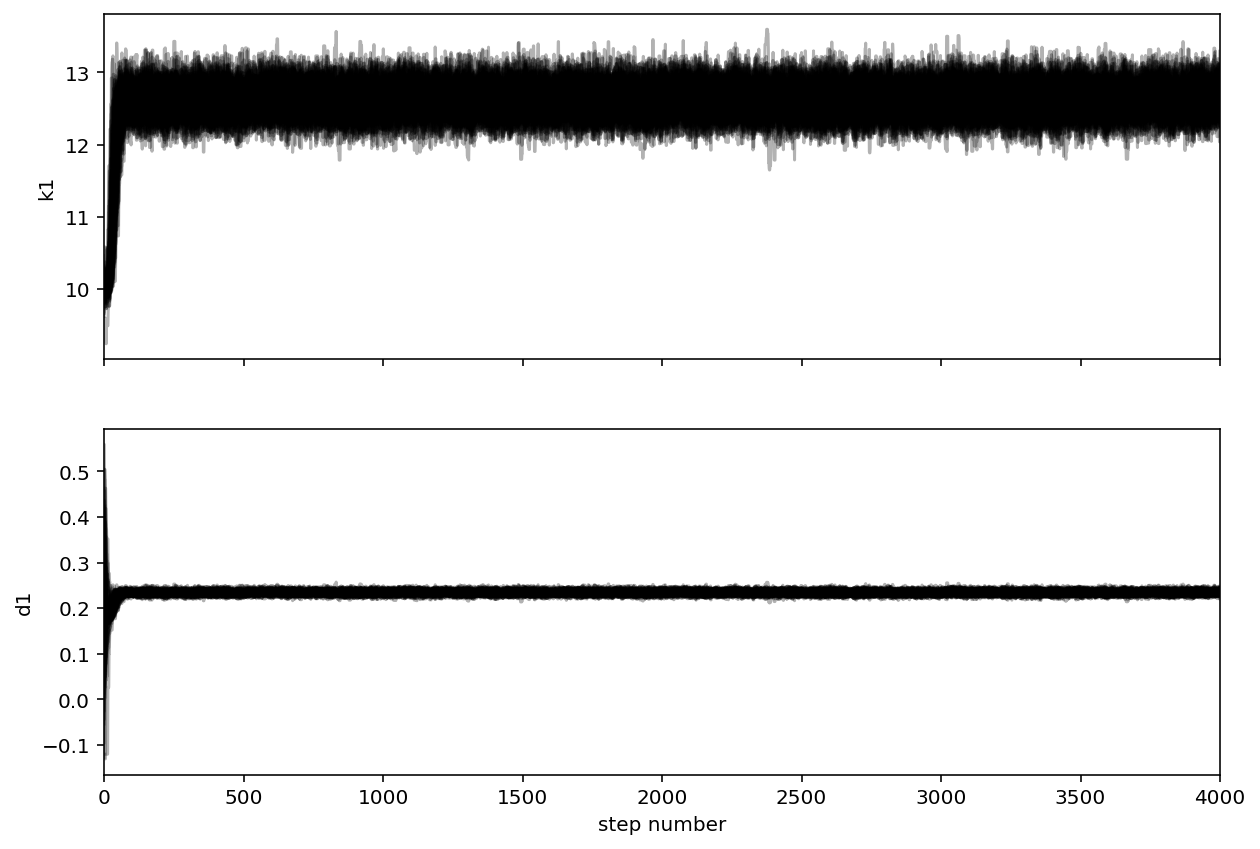

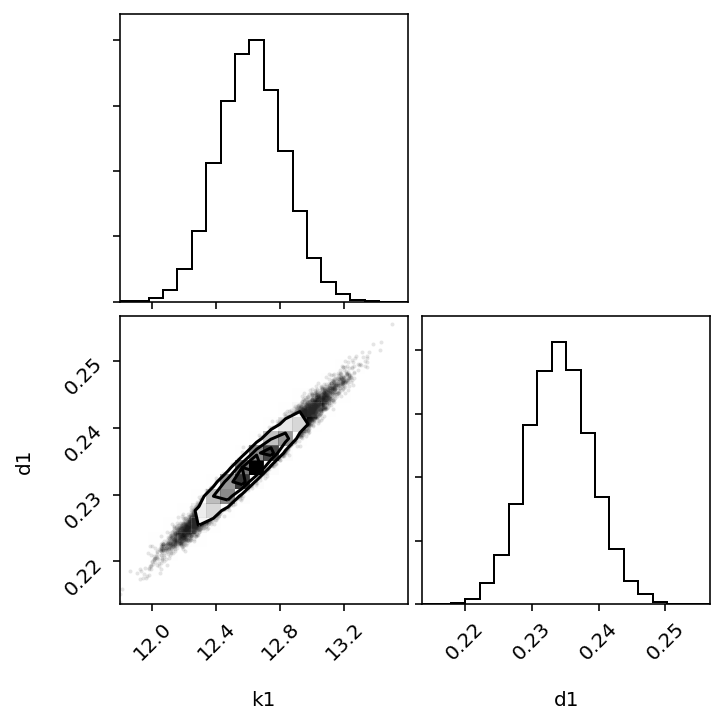

In [6]:

pid = initialize_mcmc(Model = M)

# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)

pid.set_exp_data(exp_data)
# pid.set_exp_data(list_of_dfs)
pid.set_measurements(['X'])
pid.set_time_column(['timepoints'])
pid.set_params_to_estimate(['k1','d1'])
pid.set_nwalkers(100)
pid.set_init_seed(0.15)
pid.set_nsteps(4000)
pid.set_sim_type('deterministic')

# Higher the probability threshold, you have wider priors. 
# Allowing lower probabilities with lower threshold implies stricter priors.
# prior = {'d1' : ['gaussian', 0, 10, 1e-3], 'k1' : ['gaussian', 0, 50, 1e-4]}
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}
# prior = {'d1' : ['uniform', 0, 20]}
pid.set_prior(prior)

sampler = pid.run_mcmc(plot_show = True)
pid.plot_mcmc_results(sampler);

Parameter posterior distribution convergence plots:


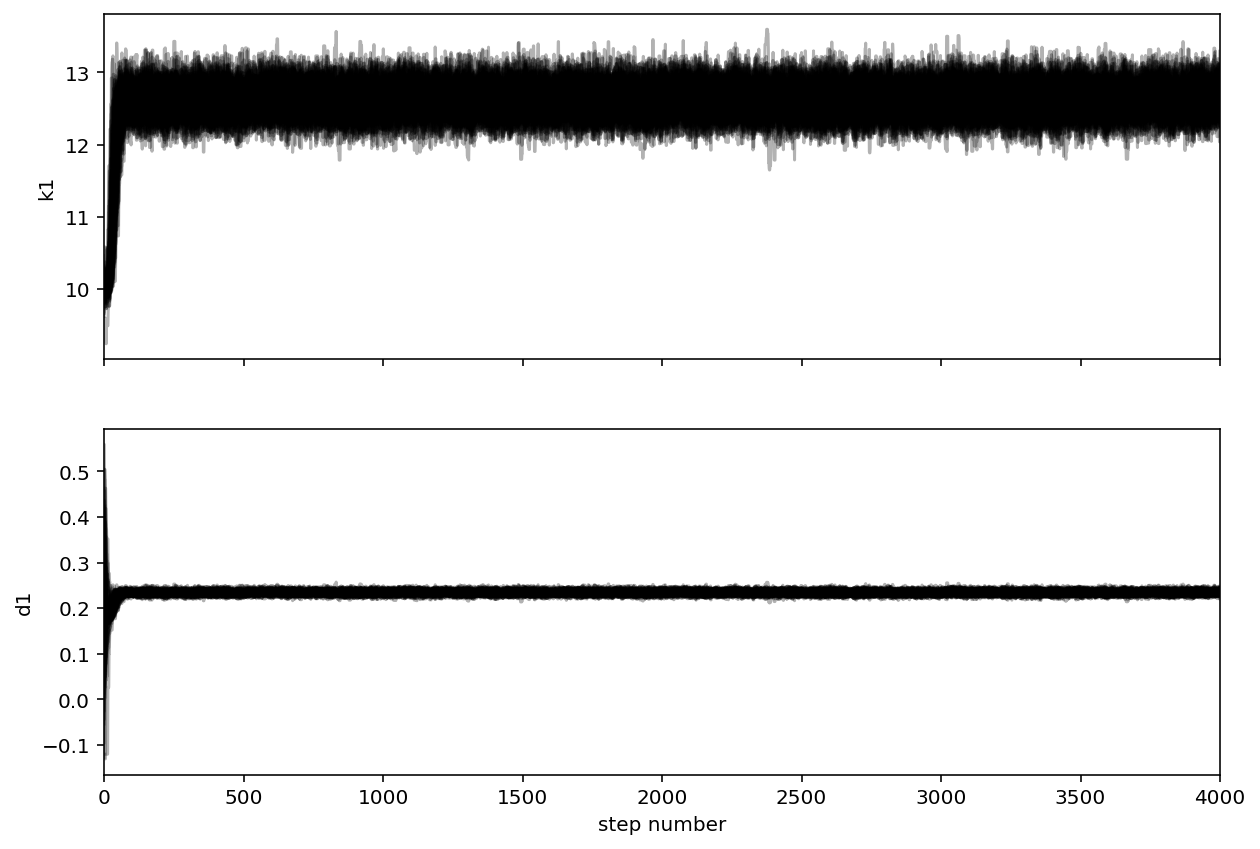

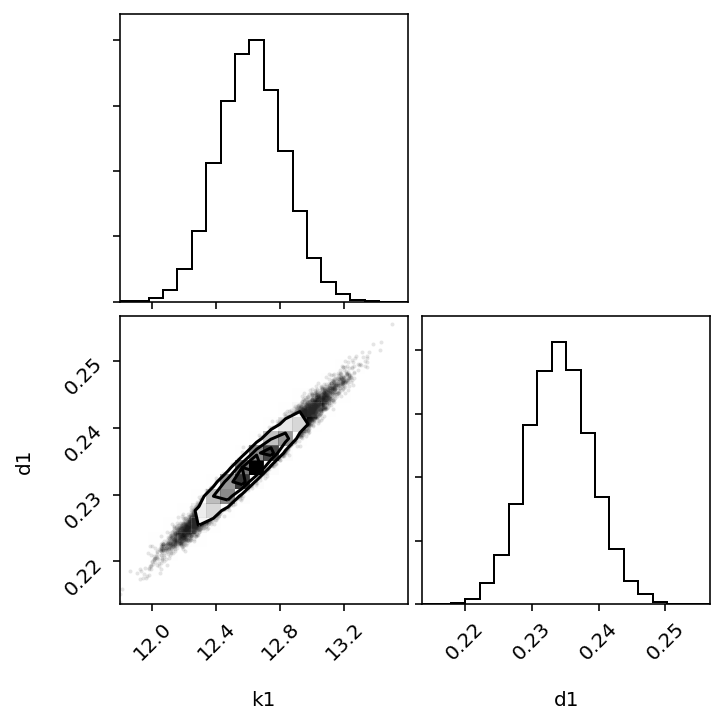

In [7]:
pid.plot_mcmc_results(sampler);

### Check mcmc_results.csv for the results of the MCMC procedure and perform your own analysis.

# OR

### You can also plot the results as follows

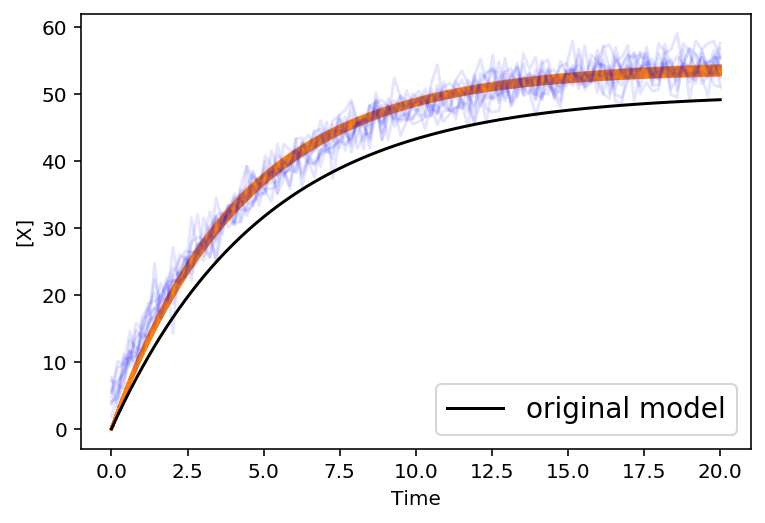

In [8]:
M_fit = Model('toy_model.xml')
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    for pi, pi_val in zip(pid.params_to_estimate, sample):
        M_fit.set_parameter(pi, pi_val)
    plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
plt.plot(timepoints, result, "k", label="original model")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

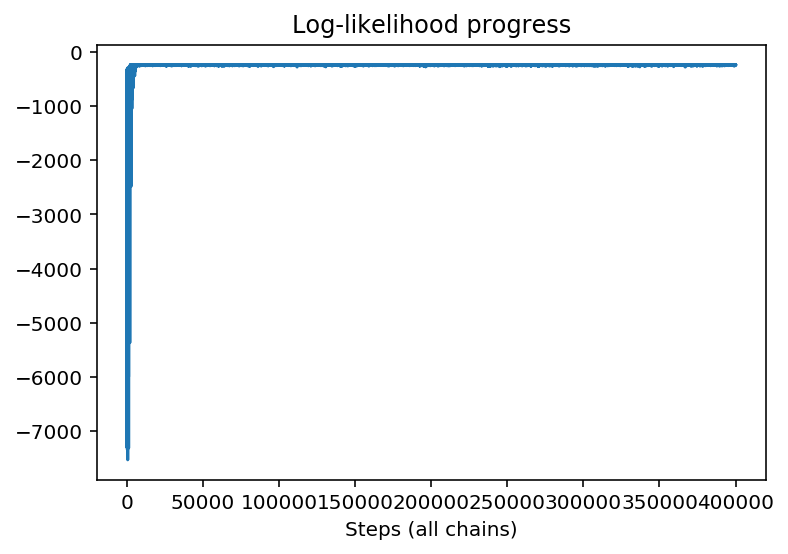

In [9]:
plt.close()
plt.title('Log-likelihood progress')
plt.plot(pid.cost_progress)
plt.xlabel('Steps (all chains)')
plt.show()

## Alll methods above have other advanced options that you can use. Refer to Parameter Identification Tools and Advanced Examples notebook for more details. There are many other tools available such as for multiple initial conditions and timepoints for each trajectory, options for the estimator etc.